In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


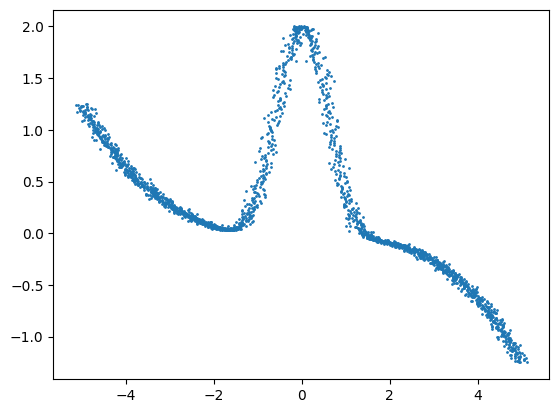

In [3]:
# 비선형회귀 1차원 문제설정
xs = np.linspace(-5,5,2000) #-5부터 5까지 2000의 배열
ys = []
for idx,x in enumerate(xs): #enumerate(xs): xs의 각 요소와 인덱스를 튜플 형태로 반환, xs의 각 요소를 반복하면서 인덱스 idx와 요소 x를 동시에 사용
    xs[idx] = x+0.1*np.random.normal()
    y_value = -0.01*x**3+2*np.cos(x)*np.exp(-x**2)
    ys.append(y_value)
ys = np.array(ys)
plt.plot(xs,ys,'o',markersize=1) # 그래프 출력

In [16]:
print(int(0.2*len(xs)))
print(len(xs))

268
1343


In [19]:
# 훈련,검증,테스트 데이터 분리
#테스트용 데이터 268개 추출 
test_idx = np.random.randint(0,len(xs),int(0.2*len(xs))) # 0이상 len(xs) 미만의  xs 리스트 길이의 20% 개수(268)만큼 정수를 무작위로 생성
x_test = xs[test_idx]
y_test = ys[test_idx]


""" ----------------------------------
아래와 같음
mask = [True] * len(xs)
for i in test_idx:
    mask[i] = False---------- """

mask = np.ones(len(xs),dtype=bool) #true 배열 생성 
mask[test_idx] = False
xs = xs[mask,...] # mask가 True인 행을 선택
ys = ys[mask,...]

#검증용 데이터 268개 추출
validation_idx = np.random.randint(0,len(xs),int(0.2*len(xs)))
x_valid = xs[validation_idx]
y_valid = ys[validation_idx]

mask = np.ones(len(xs),dtype=bool)
mask[validation_idx]=False
x_train = xs[mask,...]
y_train = ys[mask,...]

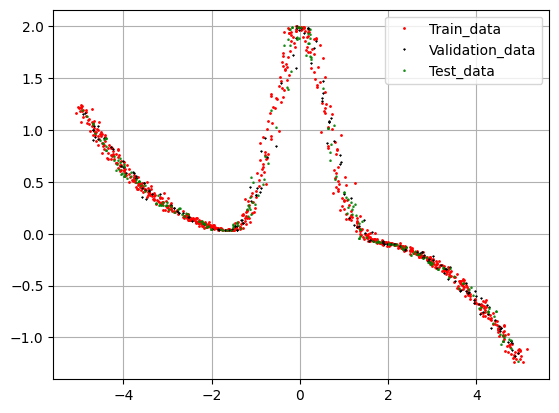

In [21]:
# x_train과 y_train 데이터를 빨간색 원형 마커로 그림
plt.plot(x_train, y_train, 'ro', markersize=1, label='Train_data')
# 'ro': red circle, 빨간색 원형 마커

# x_valid와 y_valid 데이터를 검은색 별형 마커로 그림
plt.plot(x_valid, y_valid, 'k*', markersize=1, label='Validation_data')
# 'k*': black star, 검은색 별형 마커

plt.plot(x_test, y_test, 'g^', markersize=1, label='Test_data')
# 'g^': green triangle, 초록색 삼각형 마커

# 그래프에 그리드 추가
plt.grid()
# 범례 표시
plt.legend()
# 그래프를 화면에 출력
plt.show()

In [24]:
# 데이터셋 클래스 정의
class MyDataset(Dataset):
    # 초기화 메서드 (생성자)
    def __init__(self, x, y):
        # 입력 데이터를 텐서로 변환하고, 디바이스에 맞게 이동시킨 후 (GPU) 뷰를 조정함
        self.x = torch.Tensor(x).to(device).view(-1, 1) #(-1, 1)은 텐서를 2차원 텐서로 변환하며, 첫 번째 차원은 자동으로 맞춰지고 두 번째 차원은 1로 설정
        self.y = torch.Tensor(y).to(device).view(-1, 1)
        
        # x와 y는 각각 (N, 1) 형태의 텐서가 됨

    # 인덱스를 사용하여 데이터셋의 특정 아이템을 반환하는 메서드
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
        # idx에 해당하는 x와 y 값을 반환함

    # 데이터셋의 길이를 반환하는 메서드
    def __len__(self):
        return len(self.x)
        # x 텐서의 길이 (즉, 데이터 포인트의 개수)를 반환함

In [27]:
# 정규화
x_min,x_max = x_train.min(),x_train.max()
y_min,y_max = y_train.min(),y_train.max()
def normalization(x,y):
    '''
    목적: Min-Max Normalization
    입력: x,y
    출력: 정규화된 x,y
    '''
    x = (x-x_min)/(x_max-x_min)
    y = (y-y_min)/(y_max-y_min)
    return x,y

def unnormalization(x,y):
    '''
    목적: 정규화 복원함수
    입력: x,y
    출력: 정규화 복원된 x,y
x* 정규화된 값에 데이터 셋범위 곱하기: 0과 1 사이의 값을 원래 데이터 범위로 확장
+x_min 확장된 값에 데이터셋의 최소값을 더한다.최종 복원된다. 
    '''
    x = x*(x_max-x_min)+x_min
    y = y*(y_max-y_min)+y_min
    return x,y

In [28]:
# 훈련-검증 데이터 정규화
x_train,y_train = normalization(x_train,y_train)
x_valid,y_valid = normalization(x_valid,y_valid)

In [29]:
print(x_train.min(),x_train.max())
print(y_train.min(),y_train.max())
print(x_valid.min(),x_valid.max())
print(y_valid.min(),y_valid.max())

0.0 1.0
0.0 1.0
0.014888381710815753 0.9795380146260859
0.01814533274266709 1.0000000000965212


In [30]:
# 데이터셋 및 데이터로더 정의
train_dataset = MyDataset(x_train,y_train)
valid_dataset = MyDataset(x_valid,y_valid)

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=32,shuffle=False)

tensor([[0.0123],
        [0.0139],
        [0.0114],
        [0.0054],
        [0.0078],
        [0.0117],
        [0.0352],
        [0.0217],
        [0.0157],
        [0.0125],
        [0.0094],
        [0.0232],
        [0.0000],
        [0.0229],
        [0.0151],
        [0.0299],
        [0.0266],
        [0.0396],
        [0.0114],
        [0.0514],
        [0.0348],
        [0.0248],
        [0.0379],
        [0.0299],
        [0.0368],
        [0.0351],
        [0.0400],
        [0.0462],
        [0.0493],
        [0.0396],
        [0.0309],
        [0.0546],
        [0.0445],
        [0.0416],
        [0.0537],
        [0.0573],
        [0.0381],
        [0.0636],
        [0.0432],
        [0.0484],
        [0.0561],
        [0.0643],
        [0.0513],
        [0.0448],
        [0.0656],
        [0.0581],
        [0.0488],
        [0.0632],
        [0.0736],
        [0.0595],
        [0.0774],
        [0.0712],
        [0.0810],
        [0.0777],
        [0.0624],
        [0

In [32]:
# 신경망 제작 완전 연결 계층 은닉 3층, 모든 은닉 노드를 32개로 구성, 출력층을 제외한 모든 활성화 함수는 tanh
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
       
        self.lin1 = nn.Linear(1, 32) # 첫 번째 완전 연결 계층 (입력: 1, 출력: 32)
        self.lin2 = nn.Linear(32, 32)
        self.lin3 = nn.Linear(32, 32)
        self.lin4 = nn.Linear(32, 1)
        
    # 순전파 정의
    def forward(self, x):
        # 첫 번째 은닉층: 선형 변환 후 ELU 활성화 함수 적용
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)   # 출력층: 선형 변환만 적용 (활성화 함수 없음)
        return x

In [45]:
model = MyModel().to(device)
# Adam 옵티마이저 설정
# learning rate : 0.0001
# weight_decay 가중치 감쇠: 1e-12 (L2 정규화)
#모델의 학습 가능한 파라미터들을 옵티마이저에 전달
optimizer = optim.Adam(model.parameters(),lr=1e-04,weight_decay=1e-12)

In [46]:
criterion = nn.MSELoss()

In [47]:
for epoch in range(2000):
    train_loss, valid_loss = 0, 0
    cnt_train, cnt_valid = 0, 0
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        y_infer = model(x)
        loss = criterion(y_infer,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        cnt_train += 1
    #'torch.no_grad()': 파이토치에서 그래디언트 계산을 비활성화하는 컨텍스트 매니저
# 이 블록 내에서는 그래디언트 계산이 필요 없으므로 메모리와 계산 자원을 절약 주로 모델 평가나 예측 시 사용
    with torch.no_grad():
        for x, y in valid_dataloader:
            # 입력 데이터(x)와 실제 라벨(y)을 GPU 또는 CPU로 이동
            x = x.to(device)
            y = y.to(device)
        
            # 모델을 사용하여 예측 값을 계산
            y_infer = model(x)
            # 예측 값(y_infer)과 실제 라벨(y) 간의 손실(loss)을 계산
            loss = criterion(y_infer, y)
            # 손실 값을 valid_loss에 누적
            valid_loss += loss.item()
            # 검증 데이터 배치 개수를 증가
            cnt_valid += 1
    # 에포크가 100의 배수일 때마다 학습 정보를 출력합니다.
    if epoch % 100 == 0:
        print(f'{epoch} Epoch 학습정보')
        # 학습 데이터와 검증 데이터의 평균 손실 값을 출력
        print(f'Loss: {train_loss/cnt_train:.4f}(Train_data),  {valid_loss/cnt_valid:.4f}(Validation_data)')

0 Epoch 학습정보
Loss: 0.5312(Train_data),  0.4351(Validation_data)
100 Epoch 학습정보
Loss: 0.0284(Train_data),  0.0298(Validation_data)
200 Epoch 학습정보
Loss: 0.0253(Train_data),  0.0251(Validation_data)
300 Epoch 학습정보
Loss: 0.0230(Train_data),  0.0221(Validation_data)
400 Epoch 학습정보
Loss: 0.0199(Train_data),  0.0183(Validation_data)
500 Epoch 학습정보
Loss: 0.0090(Train_data),  0.0091(Validation_data)
600 Epoch 학습정보
Loss: 0.0048(Train_data),  0.0048(Validation_data)
700 Epoch 학습정보
Loss: 0.0032(Train_data),  0.0028(Validation_data)
800 Epoch 학습정보
Loss: 0.0021(Train_data),  0.0020(Validation_data)
900 Epoch 학습정보
Loss: 0.0015(Train_data),  0.0016(Validation_data)
1000 Epoch 학습정보
Loss: 0.0011(Train_data),  0.0011(Validation_data)
1100 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0010(Validation_data)
1200 Epoch 학습정보
Loss: 0.0007(Train_data),  0.0007(Validation_data)
1300 Epoch 학습정보
Loss: 0.0006(Train_data),  0.0006(Validation_data)
1400 Epoch 학습정보
Loss: 0.0006(Train_data),  0.0006(Validation_data)
1500 Ep

In [ ]:
# 학습 종료후 데이터 복원하여 성능 평가
x_train,y_train = unnormalization(x_train,y_train)
x_test,y_test = normalization(x_test,y_test)

In [16]:
x_test_torch = torch.Tensor(x_test).view(-1,1)
y_test_torch = torch.Tensor(y_test).view(-1,1)
y_test_infer = model(x_test_torch)
loss = criterion(y_test_infer,y_test_torch).item()
print(f'테스트 데이터셋 L2_error: {loss}')

테스트 데이터셋 L2_error: 0.0010378377046436071


In [17]:
x_infer = torch.linspace(-5,5,100).view(-1,1)
# x -> normalization
x_infer = (x_infer-x_train.min())/(x_train.max()-x_train.min())
y_infer = model(x_infer)
x_infer = x_infer.detach().cpu().numpy().reshape(-1,)
y_infer = y_infer.detach().cpu().numpy().reshape(-1,)
x_infer,y_infer = unnormalization(x_infer,y_infer)

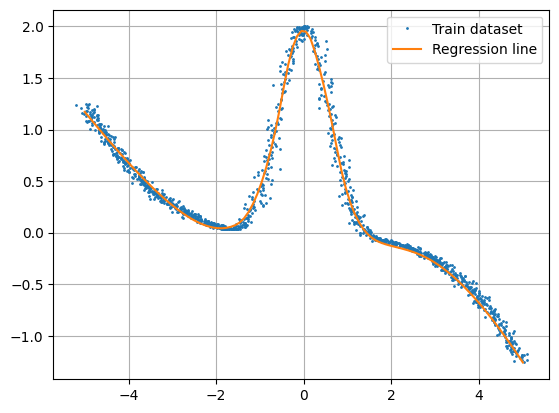

In [20]:
plt.plot(x_train,y_train,'o',markersize=1,label='Train dataset')
plt.plot(x_infer,y_infer,'-',markersize=1,label='Regression line')
plt.grid()
plt.legend()